image-data/P106-Fg002-R-C01-R01-binarized.jpg


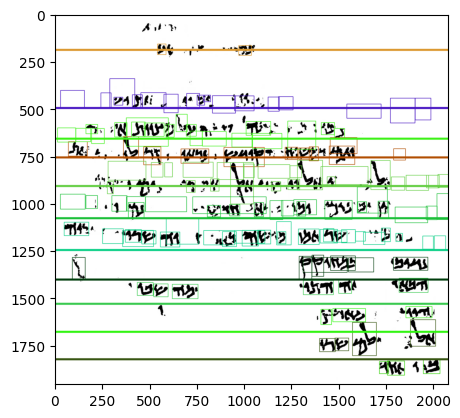

image-data/P123-Fg001-R-C01-R01-binarized.jpg


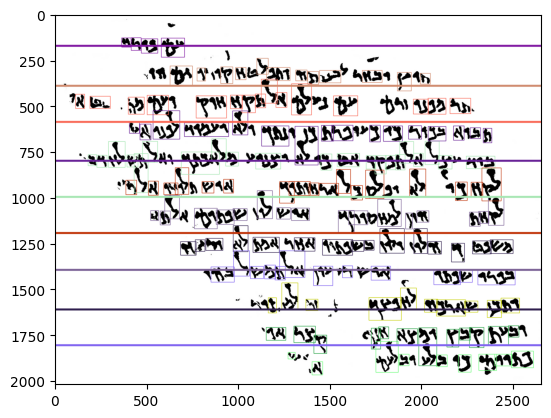

image-data/P123-Fg002-R-C01-R01-binarized.jpg


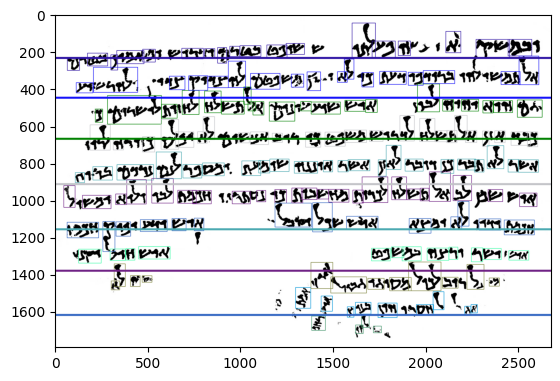

image-data/P166-Fg002-R-C01-R01-binarized.jpg


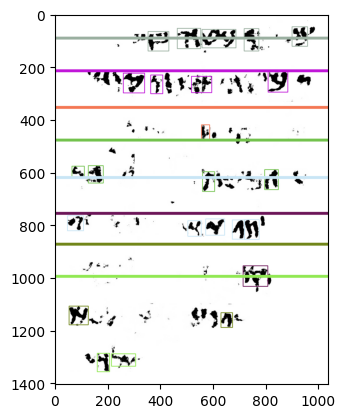

image-data/P166-Fg007-R-C01-R01-binarized.jpg


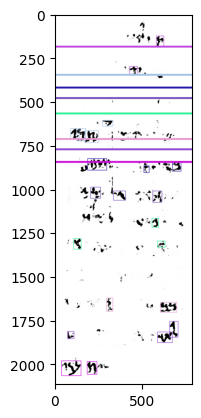

image-data/P168-Fg016-R-C01-R01-binarized.jpg


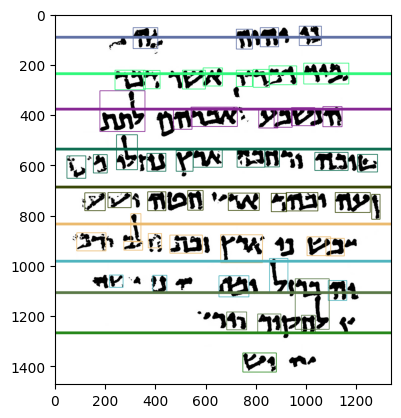

image-data/P172-Fg001-R-C01-R01-binarized.jpg


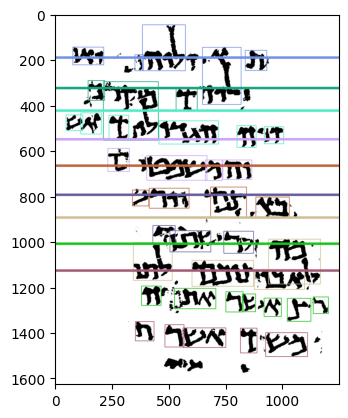

image-data/P21-Fg006-R-C01-R01-binarized.jpg


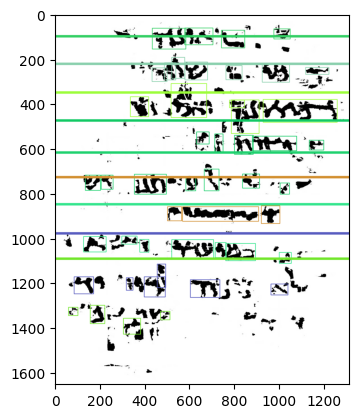

image-data/P22-Fg008-R-C01-R01-binarized.jpg


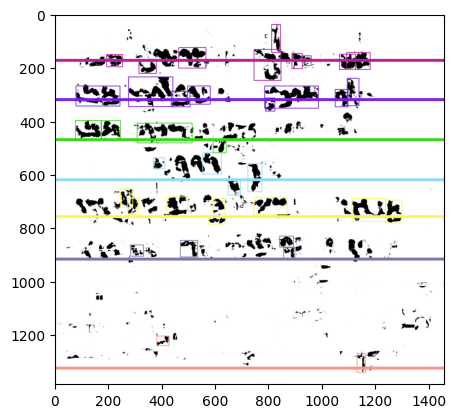

image-data/P342-Fg001-R-C01-R01-binarized.jpg


KeyboardInterrupt: 

In [6]:
from segment import Segment
import matplotlib.pyplot as plt
import shutil
import os

imagePath2 = "image-data/P106-Fg002-R-C01-R01-binarized.jpg"
sourceFolder = "image-data"
segmentationsFolder = "Data/Segmented/"

if __name__ == "__main__":
    


    for filename in os.listdir(sourceFolder):
        if 'binarized' in filename:
            segmenter = Segment(input_folder=sourceFolder)
            #morph = segmenter.segment_characters()
            imagePath = sourceFolder + "/" + filename
            print(imagePath)

            segmenter.segment_page(path=imagePath)
            img, BOUNDING_BOXES, Y_CENTERS, X_CENTERS = plotSegmentedBBs(imagePath)
            clusteryBoi(img, Y_CENTERS, X_CENTERS)

            shutil.rmtree(segmentationsFolder)



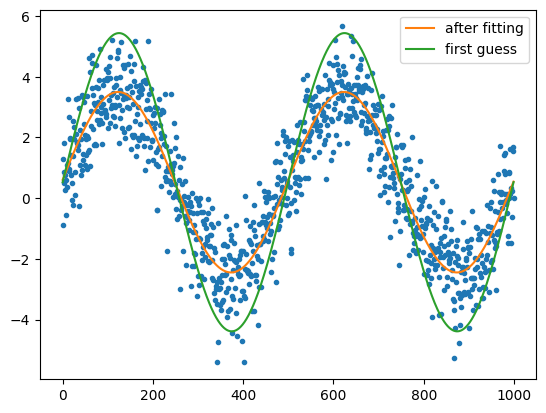

In [33]:
import numpy as np
from scipy.optimize import curve_fit
import pylab as plt

N = 1000 # number of data points
t = np.linspace(0, 4*np.pi, N)
data = 3.0*np.sin(t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

guess_freq = 1
guess_amplitude = 3*np.std(data)/(2**0.5)
guess_phase = 0
guess_offset = np.mean(data)

p0=[guess_freq, guess_amplitude,
    guess_phase, guess_offset]

# create the function we want to fit
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# now do the fit
fit = curve_fit(my_sin, t, data, p0=p0)

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = my_sin(t, *p0)

# recreate the fitted curve using the optimized parameters
data_fit = my_sin(t, *fit[0])

plt.plot(data, '.')
plt.plot(data_fit, label='after fitting')
plt.plot(data_first_guess, label='first guess')
plt.legend()
plt.show()

[[  0.9961947    0.08715574 -60.68164453]
 [ -0.08715574   0.9961947   73.16184061]]


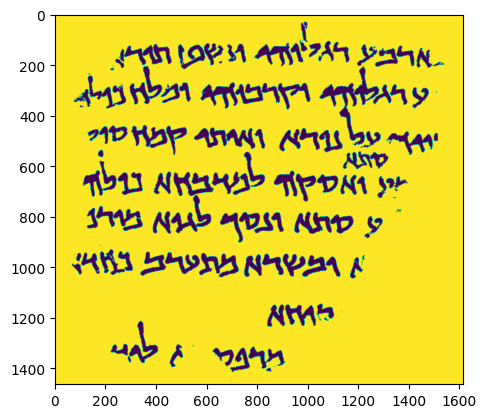

In [4]:
from data_management.augmentation.commonAug import imageRotator
import random

def rotatePage(img, angle=15):
    rows, cols = img.shape

    img_center = (cols / 2, rows / 2)
    M = cv2.getRotationMatrix2D(img_center, angle, 1)
    print(M)
    rotated_image = cv2.warpAffine(img, M, (cols, rows),
                           borderMode=cv2.BORDER_CONSTANT,
                           borderValue=(255))
    
    return rotated_image


rotated = rotatePage(image, 5)
plt.imshow(rotated)


In [1]:
import os
import cv2
import numpy as np
from data_management.augmentation.commonAug import whitespaceRemover



segmentationsFolder = "Data/Segmented/"


def plotSegmentedBBs(imagePath, padding=50):
    img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)

    gray = img.copy() # Read in the image and convert to grayscale

    img = whitespaceRemover(img=gray, padding=50)

    BOUNDING_BOXES = []
    Y_CENTERS = []
    X_CENTERS = []

    for filename in os.listdir(segmentationsFolder):
        splitName = filename.replace('_', ' ').replace("=", ' ').replace(".", ' ').split()
        x = int(splitName[-8]) 
        y = int(splitName[-6]) 
        w = int(splitName[-4])
        h = int(splitName[-2])

        BOUNDING_BOXES.append([x,y,w,h])
        Y_CENTERS.append(y + (h/2)) # get the center point og the BB
        X_CENTERS.append(x + (w/2))

        img = cv2.rectangle(img, (x,y), (x+w, y+h), color = (0,0,0), thickness=2)

    return img, BOUNDING_BOXES, Y_CENTERS, X_CENTERS


In [5]:
from sklearn.cluster import KMeans
from sklearn import preprocessing as pre


def clusteryBoi(img, Y_CENTERS, X_CENTERS):

    Y_in = np.array(Y_CENTERS).reshape(-1, 1)
    scaler = pre.MinMaxScaler()
    Y_in = scaler.fit_transform(Y_in)

    Y_in *= 10 / (img.shape[0] / img.shape[1]) # scale the y coords here

    k = findOptimalK(Y_in)

    model = KMeans(n_clusters=k)
    preds = model.fit_predict(Y_in)

    COLOURS = np.random.randint(0, 255, [k, 3])



    _, imWidth = img.shape

    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

    for idx, [x,y,w,h] in enumerate(BOUNDING_BOXES):
        colour = COLOURS[preds[idx]]
        #print(colour)
        colour = (int(colour[0]), int(colour[1]), int(colour[2]))
        #print(colour)
        cv2.rectangle(img, (x,y), (x+w, y+h), color = colour, thickness=2)


    #plt.imshow(img)
    #plt.show()


    lines_img = img.copy()

    centers = scaler.inverse_transform(model.cluster_centers_ / 10)

    for idx, cluster_center in enumerate(centers):
        cluster_center = int(cluster_center)

        colour = COLOURS[idx]
        #print(colour)
        colour = (int(colour[0]), int(colour[1]), int(colour[2]))

        cv2.line(lines_img, (0, cluster_center), (imWidth, cluster_center), color = colour, thickness=10)



    plt.imshow(lines_img)
    plt.show()

In [3]:
from sklearn.metrics import silhouette_score

def findOptimalK(data, start=2, end=20):
    inertia = []
    silhouette_scores = []

    for k in range(start,end):
        # make and fit the K-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        # calculate inertia
        MSD = kmeans.inertia_
        RMSD = np.sqrt(MSD)
        inertia.append(RMSD)

        # calculate silhouette score
        sil_score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(sil_score)

    # the best value for K is the one with the highest silhouette score
    optimal = silhouette_scores.index(max(silhouette_scores))  +  start


    return optimal

## FUCK


In [1]:
from segmentFunction import segment_dss_page
import cv2
import numpy as np
import matplotlib.pyplot as plt
from data_management.augmentation.commonAug import whitespaceRemover

img_path = "image-data/P513-Fg001-R-C01-R01-binarized.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Read the img
img = whitespaceRemover(img=img, padding=20)

drawingBoi = img.copy()

BBs = segment_dss_page(img)

bb = BBs[10] #XMIN,YMIN,XMAX,YMAX
angle = 6 #Rotation angle in degrees, +ve is counter-clockwise

bb = np.array(((bb[0],bb[1]),(bb[0],bb[3]), (bb[2],bb[1]),(bb[2],bb[3]))) #Get all 4 coordinates of the box
# top-left, bottom-left, top-right, bottom-right

#img = cv2.imread(img_path) #Read the img

angles = np.arange(-15, 15 + 1, 5)


center = (img.shape[0]//2,img.shape[1]//2) #Get the center of the image


In [2]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing as pre



def findOptimalK(data, start=2, end=20):
    inertia = []
    silhouette_scores = []

    for k in range(start,end):
        # make and fit the K-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        # calculate inertia
        MSD = kmeans.inertia_
        RMSD = np.sqrt(MSD)
        inertia.append(RMSD)

        # calculate silhouette score
        sil_score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(sil_score)

    # the best value for K is the one with the highest silhouette score
    max_ss = max(silhouette_scores)
    optimal_k = silhouette_scores.index(max_ss)  +  start
    


    return max_ss, optimal_k

In [73]:

def rotateBB(bb, rotMat):
    bb = np.array(((bb[0],bb[1]),(bb[0],bb[3]), (bb[2],bb[1]),(bb[2],bb[3]))) #Get all 4 coordinates of the box

    bb_rotated = np.vstack((bb.T,np.array((1,1,1,1)))) #Convert the array to [x,y,1] format to dot it with the rotMat
    bb_rotated = np.dot(rotMat,bb_rotated).T #Perform Dot product and get back the points in shape of (4,2)


    xmin = int(min(bb_rotated[:,0]))
    xmax = int(max(bb_rotated[:,0]))

    ymin = int(min(bb_rotated[:,1]))
    ymax = int(max(bb_rotated[:,1]))

    return [xmin, ymin, xmax, ymax]


angles = np.arange(-15, 15 + 1, 3)
center = (img.shape[0]//2,img.shape[1]//2) #Get the center of the image


rotationMatrices = [cv2.getRotationMatrix2D(center,ang,1.0) for ang in angles]
rotatedBoundingBoxes = []

scores = []
bests = []

print(len(angles), len(rotationMatrices))


ORIGINALBBS = BBs.copy()


def rotateAndOptimiseCluster(rotationMatrix, BBs):
    best_score = 0

    #return rotatedBBs, best_k, best_score


for rotationMatrix, angle in zip(rotationMatrices, angles):

    img_rotated = cv2.warpAffine(drawingBoi.copy(),rotationMatrix,img.shape[1::-1],
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(255)) #Rotate the image

    drawim = cv2.cvtColor(img_rotated, cv2.COLOR_GRAY2RGB)
    
    rotatedBBs = [rotateBB(bb, rotationMatrix) for bb in BBs]
    rotatedBoundingBoxes.append(rotatedBBs)

    for [xmin, ymin, xmax, ymax] in rotatedBBs:
        drawim = cv2.rectangle(drawim, (xmin, ymin), (xmax, ymax), (255,0,0), 1)

    bb_y_centers = [int((bb[1] + bb[3])/2) for bb in rotatedBBs]

    for center in bb_y_centers:
        cv2.line(drawim, (0, center), (drawim.shape[1], center), color = (255,0,0), thickness=1)


    Y_in = np.array(bb_y_centers).reshape(-1, 1)
    scaler = pre.MinMaxScaler()
    Y_in = scaler.fit_transform(Y_in)

    #Y_in *= 10 / (img.shape[0] / img.shape[1])

    
    score, best_k = findOptimalK(Y_in)
    scores.append(score)
    bests.append(best_k)


    #plt.imshow(drawim)
    #plt.title(angle)

    #plt.show()


11 11


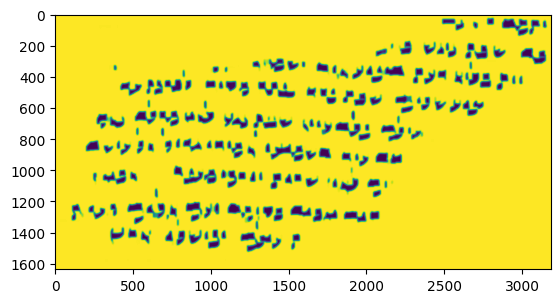

In [70]:
blurryboi = img.copy()
for i in range(3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,2))
    blurryboi = cv2.morphologyEx(blurryboi, cv2.MORPH_DILATE, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,10))
    blurryboi = cv2.morphologyEx(blurryboi, cv2.MORPH_ERODE, kernel, iterations=1)

blurryboi = cv2.GaussianBlur(blurryboi, (25, 25), 0)
plt.imshow(blurryboi)

In [2]:
from segmentation.imageRotation import find_optimal_rotation
from segmentFunction import segment_dss_page
import cv2
import numpy as np
import matplotlib.pyplot as plt
from data_management.augmentation.commonAug import whitespaceRemover

img_path = "image-data/P513-Fg001-R-C01-R01-binarized.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Read the img
img = whitespaceRemover(img=img, padding=20)

blurryboi = img.copy()
for i in range(3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,2))
    blurryboi = cv2.morphologyEx(blurryboi, cv2.MORPH_DILATE, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,10))
    blurryboi = cv2.morphologyEx(blurryboi, cv2.MORPH_ERODE, kernel, iterations=1)

blurryboi = cv2.GaussianBlur(blurryboi, (25, 25), 0)
plt.imshow(blurryboi)


rot_image, rot_line_peaks, rot_degree = find_optimal_rotation(blurryboi, "hi", runmode=2)

Degree=-10; Score=0.6666666666666666
Degree=-9; Score=0.6190476190476191
Degree=-8; Score=1.15
Degree=-7; Score=0.23809523809523808
Degree=-6; Score=0.3157894736842105
Degree=-5; Score=0.375
Degree=-4; Score=0.55
Degree=-3; Score=0.6190476190476191
Degree=-2; Score=0.8095238095238095
Degree=-1; Score=1.2352941176470589
Degree=0; Score=4.214285714285714
Degree=1; Score=6.25
Degree=2; Score=8.444444444444445
Degree=3; Score=0.09090909090909091
Degree=4; Score=0.6666666666666666
Degree=5; Score=1.3
Degree=6; Score=1.0
Degree=7; Score=0.375
Degree=8; Score=0.5882352941176471
Degree=9; Score=0.8947368421052632


<Figure size 640x480 with 0 Axes>

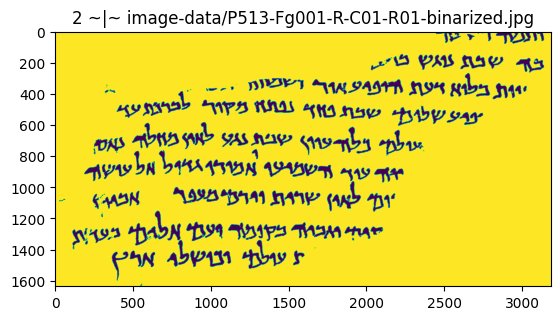

In [15]:
from skimage.transform import rotate

rotated_image = rotate(img.copy(), rot_degree, resize=False, cval=1, mode ='constant')

plt.imshow(rotated_image)
plt.title(str(rot_degree) +" ~|~ " + img_path)
plt.show()

In [7]:
scores.index(max(scores))

indx = scores.index(max(scores))
best_angle = angles[indx]
best_k = bests[indx]

print(best_angle, best_k)


3 9


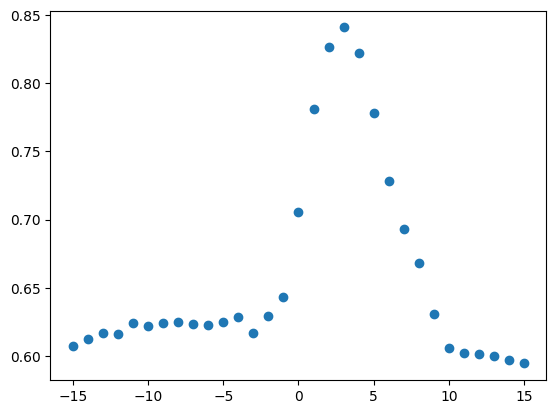

In [5]:
plt.scatter(angles, scores)

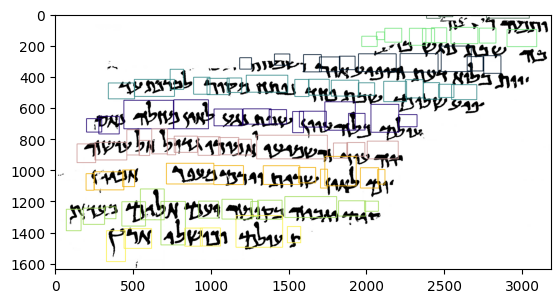

In [133]:
COLOURS = np.random.randint(0, 255, [best_k, 3])


lines_img = img.copy()
_, imWidth = lines_img.shape

center = (lines_img.shape[0]//2,lines_img.shape[1]//2) #Get the center of the image
rotMat = cv2.getRotationMatrix2D(center,best_angle,1.0) #Get the rotation matrix, its of shape 2x3

#lines_img = cv2.warpAffine(lines_img,rotMat,img.shape[1::-1],
#                             borderMode=cv2.BORDER_CONSTANT,
#                             borderValue=(255)) #Rotate the image



BBs = rotatedBoundingBoxes[indx]
BBs = ORIGINALBBS

bb_y_centers = [int((bb[1] + bb[3])/2) for bb in BBs]
Y_in = np.array(bb_y_centers).reshape(-1, 1)
scaler = pre.MinMaxScaler()
Y_in = scaler.fit_transform(Y_in)
model = KMeans(n_clusters=best_k)
preds = model.fit_predict(Y_in)


lines_img = cv2.cvtColor(lines_img,cv2.COLOR_GRAY2RGB)

for idx, [x1,y1,x2,y2] in enumerate(ORIGINALBBS):
    colour = COLOURS[preds[idx]]
    #print(preds[idx])
    #print(colour)
    colour = (int(colour[0]), int(colour[1]), int(colour[2]))
    #print(colour)
    cv2.rectangle(lines_img, (x1,y1), (x2,y2), color = colour, thickness=3)
    #print(x1, y1)



centers = scaler.inverse_transform(model.cluster_centers_)

for idx, cluster_center in enumerate(centers):
    cluster_center = int(cluster_center)

    colour = COLOURS[idx]
    #print(colour)
    colour = (int(colour[0]), int(colour[1]), int(colour[2]))

    #cv2.line(lines_img, (0, cluster_center), (imWidth, cluster_center), color = colour, thickness=10)



plt.imshow(lines_img)
plt.show()